In [1]:
from ClusterMap.clustermap import *
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io

# Read spots and dapi image

In [2]:
genes=pd.read_csv('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\genes.csv',header=None)

### set radius parameters
xy_radius=20
z_radius=10

# Cell segmentation loop over position

In [3]:
for positionid in range(1220,2119):
    print(f'-----Process position: {positionid}-----')
    position=f"{positionid:03d}"
    mat = scipy.io.loadmat('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\output\\max\\Position'+position+'\\goodPoints_max3d.mat')

    if mat['goodReads'].shape[0]>=20:
        ### read spots and dapi image
        gene=np.zeros(mat['goodReads'].shape[0]).astype('int')
        for indi,i in enumerate(mat['goodReads']):
            gene[indi]=list(genes[0]).index(i[0])
        gene=gene-min(gene)+1

        spots = pd.DataFrame(mat['goodSpots'], columns = ['spot_location_1','spot_location_2','spot_location_3'])
        spots['gene']=gene

        dapi = tifffile.imread('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\dapi\\round1\\Position'+position+'\\Position'+position+'_ch4.tif')
        dapi = np.transpose(dapi, (1,2,0))

        ### instantiate model
        num_gene=np.max(spots['gene'])
        model = ClusterMap(spots=spots, dapi=dapi, gene_list=np.arange(1,num_gene+1), num_dims=len(dapi.shape),
                           xy_radius=xy_radius,z_radius=z_radius,fast_preprocess=True)

        ### preprocessing: default: filter 10% spots out
        pct_filter=0.1
        model.preprocess(pct_filter)

        ### segmentation
        # %% time
        model.min_spot_per_cell=30
        model.segmentation(dapi_grid_interval=5,add_dapi=True,use_genedis=False)

        path_save = 'H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\ClusterMap\\' + position +'.csv'
        model.save(path_save)

# Stitch all tiles if necessary

In [5]:
import pandas as pd

In [6]:
### load configuration file
positionmapleft=pd.read_csv('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\Sagittal2-position-map_left.csv')
positionmapright=pd.read_csv('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\Sagittal2-position-map_right.csv')

spots_results = pd.DataFrame(columns=['Tile','X_init','Y_init'])
test1=positionmapleft.loc[:,['PositionID','X+','Y+']]
test1=test1.iloc[3:,:]
test1.columns=['Tile','X_init','Y_init']
spots_results=spots_results.append(test1)

test2=positionmapright.loc[:,['PositionID','Column2','Column1']]
test2.columns=['Tile','X_init','Y_init']
spots_results=spots_results.append(test2)

spots_results=spots_results.reset_index(drop=True)
spots_results['Y_init']=[int(i) for i in spots_results['Y_init']]
spots_results['X_init']=[int(i) for i in spots_results['X_init']]
spots_results['X_init']=(spots_results['X_init']-min(spots_results['X_init']))*1346
spots_results['Y_init']=(spots_results['Y_init']-min(spots_results['Y_init']))*1346
spots_results

,Tile,X_init,Y_init
0,1223,0,16152
1,1224,0,17498
2,1225,0,18844
3,1226,0,20190
4,1227,0,22882
...,...,...,...
891,2114,65954,21536
892,2115,67300,13460
893,2116,67300,14806
894,2117,67300,16152


In [7]:
spots_results.to_csv('H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\tile_config.csv')

In [8]:
path_res = 'H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\ClusterMap\\results\\'

model_stitch = StitchSpots(path_res=path_res,
                           config=spots_results,
                           res_name='clustermap')


model_stitch.size_single_img=1496

### location in tile, x, y table
model_stitch.stitch_tiles()

Stitching tiles


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [23:01<00:00,  1.54s/it]


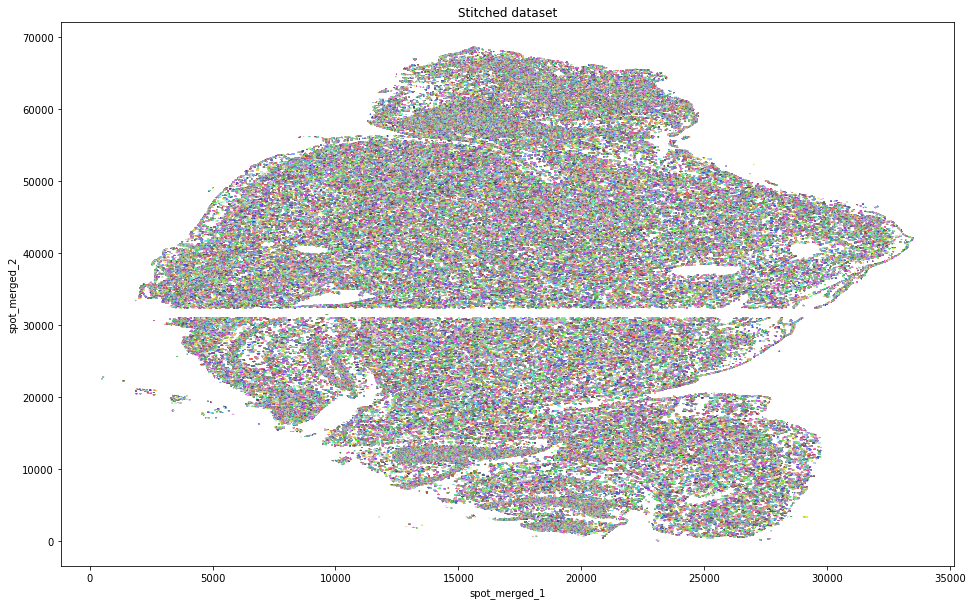

In [36]:
model_stitch.plot_stitched_data()

In [9]:
path_save = 'H:\\2021-09-17-Hailing-Yichunprocessed-sagittal2\\stitched\\spots_all.csv'
model_stitch.save_stitched_data(path_save)